In [4]:
import pandas as pd
import numpy as np
import re
import pdb
import pandas_profiling

import missingno

from textblob import TextBlob, Word
import string
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Cleaning Scraped Data
This notebooks provides a consistent process for cleaning datasets scraped at different times for analysis

## Importing new data
Update the filenames below an all other code should run with the new file

In [11]:
#name of file with scraped data (pre-set to default of output file from scraping)
input_filename = './data/new_combined_data.csv'

#filepath for saving clean data
clean_filename = './data/test_mining_plumbing_socialwork_clean.csv'

In [12]:
#importing raw data
def import_jobs(filename):
    jobs_original = pd.read_csv(filename)
    return jobs_original

jobs_original = import_jobs(input_filename)
jobs_original.head()

,company,company_rating,job_description_all_text,job_title,location,salary_data_text,industry
0,Rio Tinto,3.9,"Imagine. Realise. Provide for society. Be the progress.\r\r\nVacation student opportunities 2019-2020 Australia\r\r\nWhy is progress important to us? At Rio Tinto, your innovation will deliver the building blocks humankind relies on. Like the aluminium in our cars. The iron in our skyscrapers. And the salt that seasons our meals. This is complex work that calls for natural leadership and the ability to quickly develop new skills. Work that thrives from creative thinking and demands astute environmental stewardship. Work that ultimately shapes society and drives human progress.\r\r\n\r\r\nOur Programme\r\r\nOur Vacation Programme will give you a great taste for what it’s like to work at Rio Tinto. Over an adrenaline-charged 12 weeks from December to February you’ll work with industry experts on real projects, putting theory into practice to deliver results.\r\r\nIt’s important to us that you get the most out of this excellent opportunity. The experience you gain here will serve as a major step towards achieving your key study goal, graduating! As part of our Programme you’ll complete a number of job-based assignments related to your areas of study, with guidance and support at every step of the journey. You’ll be confident you’re one step closer to wearing that mortarboard.\r\r\nWho we’re looking for\r\r\nWe’re looking for exceptional students who want to learn. Ambitious personalities with curious and analytical minds. Those excited by new environments and ready for the challenge ahead.\r\r\nWe’re seeking university students studying in the following fields: Chemical / Process Engineering Civil / Structural Engineering Commerce / Finance Computer Science / Software Engineering Data Science / Data Analytics Electrical / Control Systems Engineering Environment Geology / Geoscience Geotechnical Engineering Health and Safety Human Resources Hydrogeology Hydrology Information Systems and Technology Materials Engineering Mechanical Engineering Metallurgy Mining Engineering Robotics / Mechatronics Engineering Statistics / Mathematics Surveying\r\r\n Our roles are based in regional and capital cities across the country. We offer fly-in-fly-out rosters and residential placements.\r\r\nFor students in their penultimate or final year, the Rio Tinto Vacation Programme is a great opportunity should you wish to be considered for a Graduate position with us in 2021.\r\r\nApplications close 25 August 2019.\r\r\nBe the progress. Apply today.",Rio Tinto Vacation Programme 2019-2020 Australia,melbourne,NaN,mining
1,Mideco Jia Pty Ltd,NaN,"Mideco has been a recommended supplier in Australia for industrial and commercial dust extraction systems for the past 60 years.We work with all types of businesses from mining companies, cement producers, quarries to fertiliser and grain manufacturers. Mideco provides innovative approaches and can supply aAbout Mideco: wide variety of dust control solutions that can solve your dust issues.Whether you require Burnley® Baffles for a hopper dust issue, a Bat Booth™ for personnel de-dusting or one of our many dust collectors to maintain the air quality in your facility, we are prepared to work with you to ensure the best practice quality outcome.About the job opportunity: Mideco is now searching for a competent and motivated Estimating Engineer who will be in charge of collecting, analyzing data and generating information in order to estimate costs associated with manufacturing products, services and spare parts.Main responsibilities:Design dust control systems and ducting according the airflow, product being handled and application criteria.Investigate and identify cost reduction opportunities through cost analysis review and design changesLiaise with site supervisors and other engineersCost control, monitoring productivities and forecasting costs to completeManage and control of projects and documentati

In [17]:
#view dataframe profile report
pandas_profiling.ProfileReport(jobs_original)

Number of variables,7
Number of observations,7066
Total Missing (%),17.1%
Total size in memory,386.5 KiB
Average record size in memory,56.0 B
Numeric,0
Categorical,7
Boolean,0
Date,0
Text (Unique),0
Rejected,0


In [18]:
#most scraped job sets have many duplicat rows
#quick way to look at what's duplicated
def view_duplicates_by_column(df):
    
    for column in jobs_original.columns:
        print(column, jobs_original.duplicated(subset=column).sum() )

In [19]:
view_duplicates_by_column(jobs_original)

company 5609
company_rating 7035
job_description_all_text 2805
job_title 3538
location 7059
salary_data_text 6579
industry 7063


In [13]:
def drop_duplicate_jds(df):
    '''Removes all fully duplicated rows, as well as duplicated jd text and rows with no jd text'''

    new_df = df.drop_duplicates(keep='first')
    new_df = new_df.drop_duplicates(subset='job_description_all_text', keep='first')
    new_df = new_df.dropna(subset=['job_description_all_text'])
    
    return new_df

#view profile report for new df
jobs_nona = drop_duplicate_jds(jobs_nona)
pandas_profiling.ProfileReport(jobs_nona)

Number of variables,12
Number of observations,4260
Total Missing (%),35.8%
Total size in memory,432.7 KiB
Average record size in memory,104.0 B
Numeric,4
Categorical,7
Boolean,0
Date,0
Text (Unique),1
Rejected,0


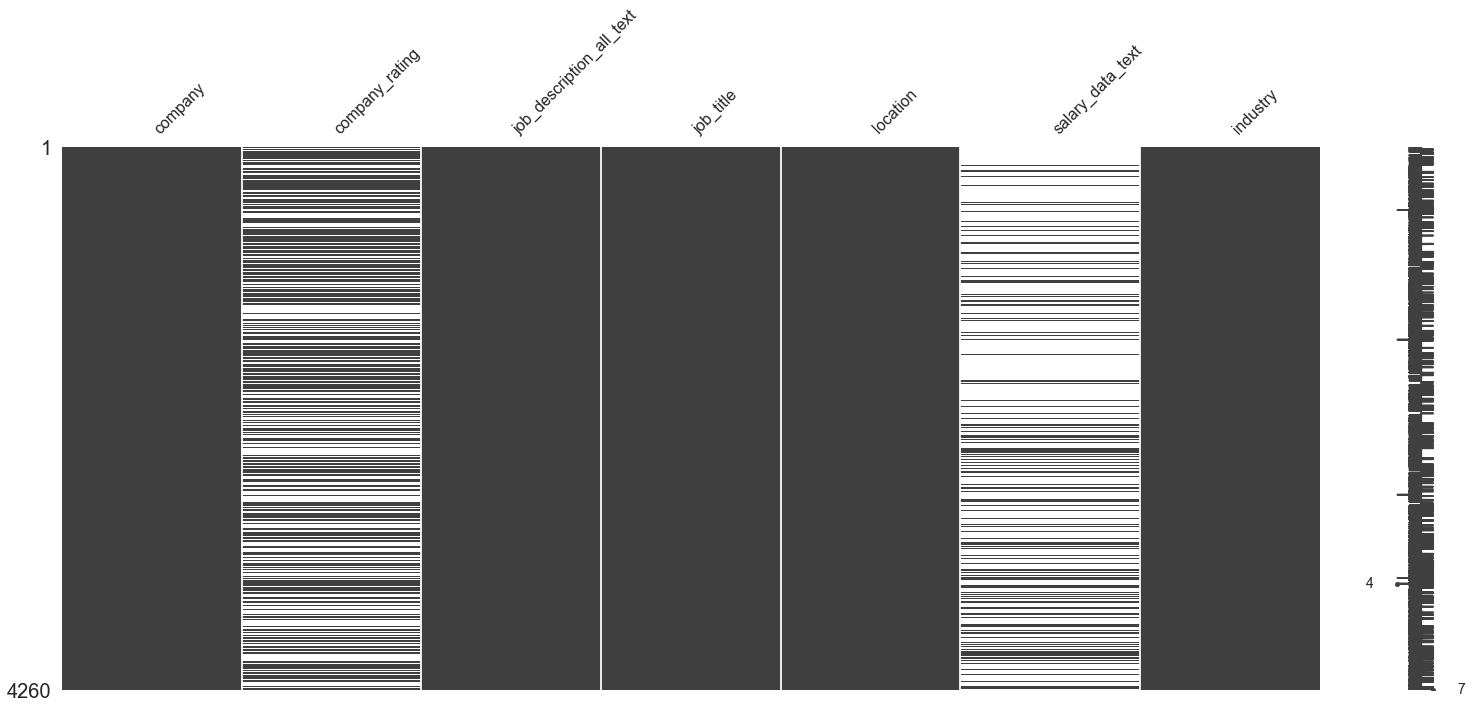

In [22]:
#visually check missing data
missingno.matrix(jobs_nona)

In [23]:
#company rating and salary are expected to be sparse
jobs_nona.isna().sum()

company                        6
company_rating              1856
job_description_all_text       0
job_title                      0
location                       0
salary_data_text            3286
industry                       0
dtype: int64

In [14]:
# Given small numbers missing in company, converting to 'unknown'
jobs_nona.company.fillna('unknown', inplace=True)
jobs_nona.isna().sum()

company                     0   
company_rating              1856
job_description_all_text    0   
job_title                   0   
location                    0   
salary_data_text            3286
industry                    0   
jd_no_stopwords             0   
salary_values               3286
salary_period               3286
salary_multiplier           3286
annual_salary               3286
dtype: int64

In [32]:
#need to convert rating to float
jobs_nona.company_rating.unique()

array(['3.9', nan, '4.3', '3.5', '4 o', '3.7', '3.4', '2.8', '3.8', '4.2',
       '3.3', '3.1', '2.9', '4.1', '3.6', '2.4', '3 o', '2.6', '5 o',
       '4.5', '3.2', '4.7', '4.6', '2.7', '2.5', '4.9', '4.4', '4.8',
       '2 o', '2.1', '2.3'], dtype=object)

In [15]:
def convert_ratings(column):
    float_ratings = []
    for rating in column:
        try:
            float_ratings.append(float(rating))
        except:
            new_rating = rating.replace(' ', '.')
            new_rating = new_rating.replace('o', '0')
            float_ratings.append(float(new_rating))

    return float_ratings

    
jobs_nona.company_rating = convert_ratings(jobs_nona.company_rating)
jobs_nona.company_rating.unique()

array([3.9, nan, 4.3, 3.5, 4. , 3.7, 3.4, 2.8, 3.8, 4.2, 3.3, 3.1, 2.9,
       4.1, 3.6, 2.4, 3. , 2.6, 5. , 4.5, 3.2, 4.7, 4.6, 2.7, 2.5, 4.9,
       4.4, 4.8, 2. , 2.1, 2.3])

## Creating formatted jd column for later use

In [38]:
#adjust stop words here if desired
stop_words = set(stopwords.words('english')) 

In [39]:
def remove_stop_words(text_column):
    jd_no_stopwords = []
    for jd in text_column:

        translator = str.maketrans('', '', string.punctuation)
        no_stops_jd = jd.lower()
        no_stops_jd = jd.translate(translator)


        word_tokens = word_tokenize(no_stops_jd)
        filtered_jd_words = [w for w in [w.lower() for w in word_tokens] if w not in stop_words]

        jd_no_stopwords.append(filtered_jd_words)

    return jd_no_stopwords

jobs_nona['jd_no_stopwords'] = remove_stop_words(jobs_nona.job_description_all_text)

## Formatting salary data
Will create 3 columns:
* salary_value: the value provided in the jd or the mean of a range provided
* salary_period: frequency in jd e.g. hour, day, month, year
* annual_salary: convert all amounts to annual salary 

In [40]:
def find_salary_mean(salary_text):
    
    """accepts a collection of strings including salary numbers
    returns either the number in the text or the mean if multiple numbers"""
    
    try:
        find_numbers = re.findall('\d*', salary_text.replace(',', ''))
        salary_values = [int(number) for number in find_numbers if number != '']
        salary_mean = np.mean(salary_values)
    except:
        salary_mean = np.nan
        
    return salary_mean


In [43]:
jobs_nona['salary_values'] = [find_salary_mean(salary) for salary in jobs_nona.salary_data_text]

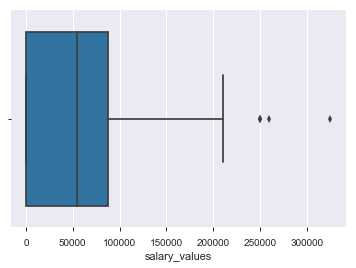

In [44]:
sns.boxplot(jobs_nona.salary_values)

In [45]:
#do outliers look valid?
jobs_nona[['salary_values','salary_data_text']][jobs_nona.salary_values > 250000]

,salary_values,salary_data_text
886,260000.0,"$250,000 - $270,000 a year"
1822,325000.0,"$250,000 - $400,000 a year"


In [47]:
def find_salary_period(salary_column, pay_lengths = ['hour','day','week','month','year']):
    
    """pulls common salary timescales out of a collection of strings describing salaries"""
    
    salary_times = []
    
    for text in salary_column:
        if type(text) != str:
            salary_times.append(None)
        else:
            salary_time = 'check'
            for option in pay_lengths:
                if option in text:
                    salary_time = option
            if salary_time != 'check':
                salary_times.append(salary_time)
            else:
                salary_times.append('unknown')

    
    return(salary_times)

In [48]:
jobs_nona['salary_period'] = find_salary_period(jobs_nona.salary_data_text)

In [49]:
#neeed to investigate any unknowns
jobs_nona.salary_period.value_counts()

year     527
hour     426
day       14
week       6
month      1
Name: salary_period, dtype: int64

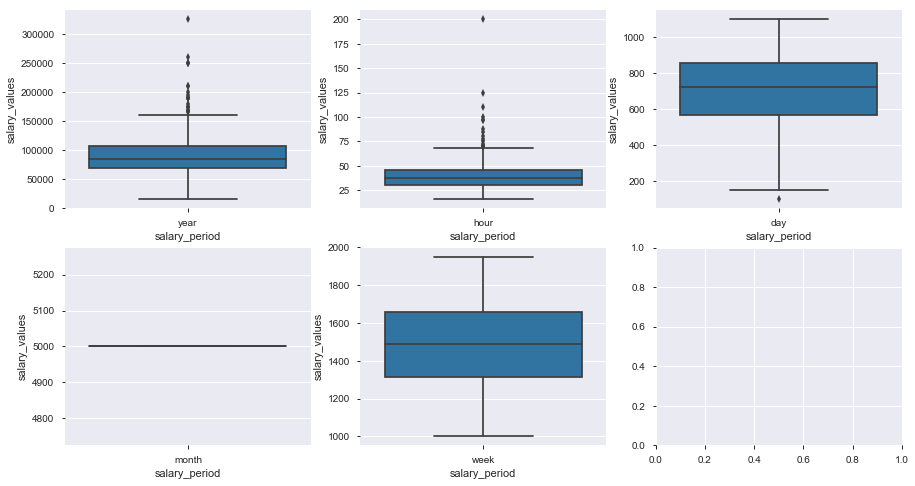

In [50]:
fig, axes = plt.subplots(2,3,figsize=(15,8))
count = 1
for time in jobs_nona.salary_period.unique():
    if type(time) == str:
        data = jobs_nona[jobs_nona.salary_period == time]
        axi = plt.subplot(2,3,count)
        sns.boxplot(x='salary_period', y='salary_values', data=data, ax=axi)
        count += 1



In [53]:
#investigating any outliers visible
jobs_nona[(jobs_nona.salary_period == 'hour') & (jobs_nona.salary_values > 180)]

,company,company_rating,job_description_all_text,job_title,location,salary_data_text,industry,jd_no_stopwords,salary_values,salary_period
5980,1 Medical,NaN,Job Title: Australia wide locum doctors requi...,Permanent and Locum Doctors required Australia...,sydney,$100 - $300 an hour,socialworker,"[job, title, australia, wide, locum, doctors, ...",200.0,hour


In [69]:

def convert_salaries(df, salary_period, salary_values):
    
    '''Converts casual/contract salary options to annual values
    df -> dateframe with your data
    salary_period -> string, name of the column with period info
    salary_values -> string, name of the column with value info
    '''
    salary_multipliers = []

    for time in df[salary_period]:

        if time == 'year':
            multiplier = 1
        elif time == 'month':
            multiplier = 12
        elif time == 'week':
            multiplier = 52
        elif time == 'day':
            multiplier = 260
        elif time == 'hour':
            multiplier = 2080 
        else:
            multiplier = None

        salary_multipliers.append(multiplier)
    
    df['salary_multiplier'] = salary_multipliers
    df['annual_salary'] = df.salary_multiplier * df.salary_values
    
    return df.annual_salary.values
    

In [72]:
jobs_nona['annual_salary'] = convert_salaries(jobs_nona, 'salary_period', 'salary_values')

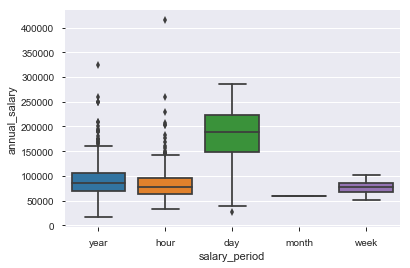

In [73]:
sns.boxplot(x='salary_period', y='annual_salary', data=jobs_nona)

## Checking industry values are as expected

In [75]:
jobs_nona.industry.value_counts()

mining          2120
socialworker    1478
plumbing         662
Name: industry, dtype: int64

## Looking at jd text

In [16]:
jobs_nona = pd.read_csv(clean_filename)
jobs_nona.head()

,company,company_rating,job_description_all_text,job_title,location,salary_data_text,industry,jd_no_stopwords,salary_values,salary_period,salary_multiplier,annual_salary
0,Rio Tinto,3.9,"Imagine. Realise. Provide for society. Be the progress.\r\r\r\nVacation student opportunities 2019-2020 Australia\r\r\r\nWhy is progress important to us? At Rio Tinto, your innovation will deliver the building blocks humankind relies on. Like the aluminium in our cars. The iron in our skyscrapers. And the salt that seasons our meals. This is complex work that calls for natural leadership and the ability to quickly develop new skills. Work that thrives from creative thinking and demands astute environmental stewardship. Work that ultimately shapes society and drives human progress.\r\r\r\n\r\r\r\nOur Programme\r\r\r\nOur Vacation Programme will give you a great taste for what it’s like to work at Rio Tinto. Over an adrenaline-charged 12 weeks from December to February you’ll work with industry experts on real projects, putting theory into practice to deliver results.\r\r\r\nIt’s important to us that you get the most out of this excellent opportunity. The experience you gain here will serve as a major step towards achieving your key study goal, graduating! As part of our Programme you’ll complete a number of job-based assignments related to your areas of study, with guidance and support at every step of the journey. You’ll be confident you’re one step closer to wearing that mortarboard.\r\r\r\nWho we’re looking for\r\r\r\nWe’re looking for exceptional students who want to learn. Ambitious personalities with curious and analytical minds. Those excited by new environments and ready for the challenge ahead.\r\r\r\nWe’re seeking university students studying in the following fields: Chemical / Process Engineering Civil / Structural Engineering Commerce / Finance Computer Science / Software Engineering Data Science / Data Analytics Electrical / Control Systems Engineering Environment Geology / Geoscience Geotechnical Engineering Health and Safety Human Resources Hydrogeology Hydrology Information Systems and Technology Materials Engineering Mechanical Engineering Metallurgy Mining Engineering Robotics / Mechatronics Engineering Statistics / Mathematics Surveying\r\r\r\n Our roles are based in regional and capital cities across the country. We offer fly-in-fly-out rosters and residential placements.\r\r\r\nFor students in their penultimate or final year, the Rio Tinto Vacation Programme is a great opportunity should you wish to be considered for a Graduate position with us in 2021.\r\r\r\nApplications close 25 August 2019.\r\r\r\nBe the progress. Apply today.",Rio Tinto Vacation Programme 2019-2020 Australia,melbourne,NaN,mining,"['imagine', 'realise', 'provide', 'society', 'progress', 'vacation', 'student', 'opportunities', '20192020', 'australia', 'progress', 'important', 'us', 'rio', 'tinto', 'innovation', 'deliver', 'building', 'blocks', 'humankind', 'relies', 'like', 'aluminium', 'cars', 'iron', 'skyscrapers', 'salt', 'seasons', 'meals', 'complex', 'work', 'calls', 'natural', 'leadership', 'ability', 'quickly', 'develop', 'new', 'skills', 'work', 'thrives', 'creative', 'thinking', 'demands', 'astute', 'environmental', 'stewardship', 'work', 'ultimately', 'shapes', 'society', 'drives', 'human', 'progress', 'programme', 'vacation', 'programme', 'give', 'great', 'taste', '’', 'like', 'work', 'rio', 'tinto', 'adrenalinecharged', '12', 'weeks', 'december', 'february', '’', 'work', 'industry', 'experts', 'real', 'projects', 'putting', 'theory', 'practice', 'deliver', 'results', '’', 'important', 'us', 'get', 'excellent', 'opportunity', 'experience', 'gain', 'serve', 'major', 'step', 'towards', 'achieving', 'key', 'study', 'goal', 'graduating', 'part', 'programme', '’', 'complete', 'number', 'jobbased', 'assignments', 'related', 'areas', 'study', 'guidance', 'support', 'every', 'step', 'journey', '’', 'confident', '’', 'one', 'step', 'closer', 'wearing',

In [17]:
pd.set_option('display.max_colwidth', -1)
jobs_nona.job_description_all_text[0]

'Imagine. Realise. Provide for society. Be the progress.\r\r\r\nVacation student opportunities 2019-2020 Australia\r\r\r\nWhy is progress important to us? At Rio Tinto, your innovation will deliver the building blocks humankind relies on. Like the aluminium in our cars. The iron in our skyscrapers. And the salt that seasons our meals. This is complex work that calls for natural leadership and the ability to quickly develop new skills. Work that thrives from creative thinking and demands astute environmental stewardship. Work that ultimately shapes society and drives human progress.\r\r\r\n\r\r\r\nOur Programme\r\r\r\nOur Vacation Programme will give you a great taste for what it’s like to work at Rio Tinto. Over an adrenaline-charged 12 weeks from December to February you’ll work with industry experts on real projects, putting theory into practice to deliver results.\r\r\r\nIt’s important to us that you get the most out of this excellent opportunity. The experience you gain here will s

In [20]:
#still has newline and return characters in jd - removing from title as well, just in case
def remove_newlines(df):
    new_df = df.copy()
    new_df.job_description_all_text = [jd.replace('\n', ' ').replace('\r', ' ') for jd in new_df.job_description_all_text]
    new_df.job_title = [title.replace('\n', ' ').replace('\r', ' ') for title in new_df.job_title]

    return(new_df)

jobs_nona = remove_newlines(jobs_nona)
jobs_nona.job_description_all_text[0]

'Imagine. Realise. Provide for society. Be the progress.    Vacation student opportunities 2019-2020 Australia    Why is progress important to us? At Rio Tinto, your innovation will deliver the building blocks humankind relies on. Like the aluminium in our cars. The iron in our skyscrapers. And the salt that seasons our meals. This is complex work that calls for natural leadership and the ability to quickly develop new skills. Work that thrives from creative thinking and demands astute environmental stewardship. Work that ultimately shapes society and drives human progress.        Our Programme    Our Vacation Programme will give you a great taste for what it’s like to work at Rio Tinto. Over an adrenaline-charged 12 weeks from December to February you’ll work with industry experts on real projects, putting theory into practice to deliver results.    It’s important to us that you get the most out of this excellent opportunity. The experience you gain here will serve as a major step tow

In [21]:
#saving new file with cleaned data
jobs_nona.to_csv(clean_filename, index=False)